In [227]:
import skimage
from skimage import io
from skimage import feature,measure
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np

In [250]:
### the data maxes out my Dropbox, so these are just my local paths...

trainfolder="/Users/gus/CDIPS/nerve-project/train/"
datafolder="/Users/gus/CDIPS/nerve-project/"
trainimages = glob.glob(os.path.join(trainfolder, '*.tif'))

In [229]:
training = pd.read_csv(os.path.join(datafolder,'train_masks.csv'))
all_training =training[['subject','img']]
non_empty=training[ ~pd.isnull(training.pixels)][['subject','img']]
empty=training[ pd.isnull(training.pixels)][['subject','img']]

In [230]:
def load_image(idx, training):
    nameformat = '{subject}_{img}.tif'
    maskformat = '{subject}_{img}_mask.tif'
    #skimage.io.imread(os.path.join(imagefolder,''))
    imagefile = nameformat.format(subject=training['subject'][idx],
                              img=training['img'][idx])
    maskfile = maskformat.format(subject=training['subject'][idx],
                              img=training['img'][idx])
    image = io.imread(os.path.join(trainfolder, imagefile))
    mask = io.imread(os.path.join(trainfolder, maskfile))   
    return (image, mask, imagefile)

In [245]:
class image_pair(object):
    
    def __init__(self,subject,img_number):
        nameformat = '{subject}_{img}.tif'
        maskformat = '{subject}_{img}_mask.tif'
        imagefile = nameformat.format(subject=subject,
                              img=img_number)
        maskfile = maskformat.format(subject=subject,
                              img=img_number)
        self.img_number = img_number
        self.subject = subject
        self.image = io.imread(os.path.join(trainfolder, imagefile))
        self.mask = io.imread(os.path.join(trainfolder, maskfile))   
        self.dims = self.image.shape
        try: 
            self.contour = measure.find_contours(self.mask, 254.5)[0]
        except:
            self.contour=np.empty((1,2))
        
    def plot(self,figure_size=(6,4)):
        title = '{subject}_{img}.tif'
        title=title.format(subject=self.subject,img=self.img_number)
        fig, ax = plt.subplots(figsize=figure_size)
        ax.imshow(self.image, cmap=plt.cm.gray)
        maskcontour = [self.contour]
        if not maskcontour==[]:
            ax.plot(maskcontour[0][:,1], maskcontour[0][:,0], linewidth=2)
            ax.set_title(title)
        else:
                ax.set_title(title + ' (no region)', fontsize=18)
        ax.set_aspect('equal')
        ax.autoscale(tight=True)
        return ax
   
    def sample_contour_negative(self,P,F=17) :
        ## this might return < P samples..
        contour= self.contour.astype(int)
        l = contour.shape[0]
        contour_pixels = set([ tuple(contour[i]) for i in xrange(l)])
        x_coords=np.random.randint(F,self.dims[0]-F,size=P)
        y_coords=np.random.randint(F,self.dims[1]-F,size=P)
        coords=zip(x_coords,y_coords)
        #print type(coords[0][0])
        #print type(tuple(contour[0])[0])
        negative = [c for c in coords if c not in contour_pixels ]
        return np.array(negative)
        

In [232]:
im=image_pair(1,4)

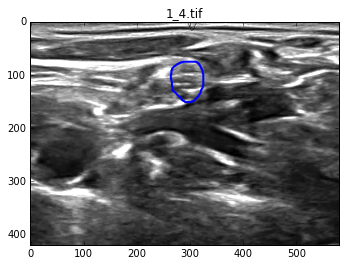

In [233]:
im.plot()

In [234]:
im.sample_contour_negative(6)

array([[151,   4],
       [196,  70],
       [341, 133],
       [221, 490],
       [350, 540],
       [300,  25]])

In [235]:
def get_patch(image,pixel,F):
        hor_range = (pixel[0]-F,pixel[0]+F+1)
        ver_range= (pixel[1]-F,pixel[1]+F+1)
        return image[hor_range[0]:hor_range[1],ver_range[0]:ver_range[1]]

In [236]:
def write_patch(patch,target_directory,subject,img,sample_number,negative=False):
    name_format='sample_{sub}_{img}_{smp}'
    path = target_directory + name_format.format(sub=subject,img=img,smp=sample_number)
    if negative == True:
        path = path+'_negative'
    np.savetxt(path,patch)

In [237]:
def sample_from_image(P,F,image_pair,target_directory):
    img = image_pair.image
    width,height = image_pair.dims
    contour=np.rint(image_pair.contour)
    total_pixels = contour.shape[0]
    sample_pixels = np.random.randint(0,total_pixels, size=P)
    for sample_num,p in enumerate(sample_pixels):
        patch = get_patch(img,contour[p],F)
        write_patch(patch,target_directory,image_pair.subject,image_pair.img_number,sample_num)
    

In [246]:
def sample_negatives_from_image(P,F,image_pair,target_directory):
    img = image_pair.image
    width,height = image_pair.dims
    sample_pixels=image_pair.sample_contour_negative(P,F)
    for sample_num, pixel in enumerate(sample_pixels):
        patch = get_patch(img,pixel,F)
        write_patch(patch,target_directory,image_pair.subject,image_pair.img_number,sample_num,negative=True)
        

In [239]:
pat=get_patch(im.image,(200,180),2)

In [240]:
sample_pixels = np.random.randint(0,20, 10)

In [241]:
# have ~2000 non-null images, let's sample from 100 of them. From each of 
# these, let's take 100 pixels.

In [242]:
target='/Users/gus/CDIPS/nerve-project/samples/'

In [243]:
def sample_positive_patches(num_images,P,F,target_directory):
    sample_images=non_empty.sample(num_images)
    ind = np.array(sample_images)
    for i in range(num_images):
        im_pair = image_pair(ind[i,0],ind[i,1])
        sample_from_image(P,F,im_pair,target_directory)

def sample_negative_patches(num_images,P,F,target_directory):
    sample_images = all_training.sample(num_images)
    ind = np.array(sample_images)
    for i in range(num_images):
        im_pair = image_pair(ind[i,0],ind[i,1])
        sample_negatives_from_image(P,F,im_pair,target_directory)

In [244]:
time sample_positive_patches(200,200,17,target)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python2.7/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


CPU times: user 46.5 s, sys: 11.2 s, total: 57.7 s
Wall time: 59.8 s


In [247]:
time sample_negative_patches(200,200,17,target)

CPU times: user 53.4 s, sys: 17.7 s, total: 1min 11s
Wall time: 1min 21s


In [252]:
patch1 = np.loadtxt('/Users/gus/CDIPS/nerve-project/samples/sample_9_75_89')
patch2 = np.loadtxt('/Users/gus/CDIPS/nerve-project/samples/sample_9_75_8')
negpatch= np.loadtxt('/Users/gus/CDIPS/nerve-project/samples/sample_32_93_93_negative')

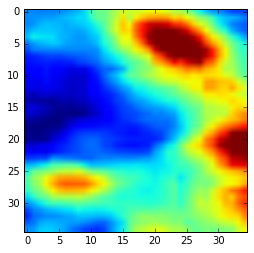

In [254]:
plt.imshow(patch1)

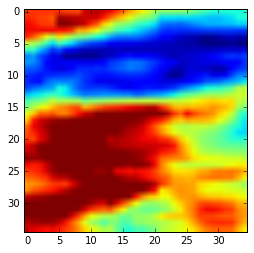

In [255]:
plt.imshow(patch2)

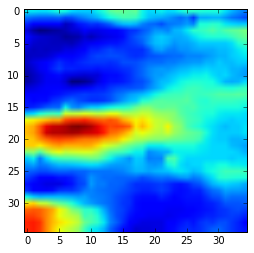

In [256]:
plt.imshow(negpatch)